# Searching for the Higgs Boson #

The Standard Model is a theory in particle physics that describes some of the most basic forces of nature. One fundamental particle, the Higgs boson, is what accounts for the *mass* of matter. First theorized in the 1964, the Higgs boson eluded observation for almost fifty years. In 2012 it was finally observed experimentally at the Large Hadron Collider. These experiments produced millions of gigabytes of data.

Large and complicated datasets like these are where deep learning excels. In this notebook, we'll build a Wide and Deep neural network to determine whether an observed particle collision produced a Higgs boson or not.

<a href="https://home.cern/science/physics/higgs-boson"><img src="https://cds.cern.ch/record/1630222/files/Candidate Higgs Events in ATLAS and CMS.png" width=400px></a>

# The Collision Data #

The collision of protons at high energy can produce new particles like the Higgs boson. These particles can't be directly observed, however, since they decay almost instantly. So to detect the presence of a new particle, we instead obesrve the behavior of the particles they decay into, their "decay products".

The *Higgs* dataset contains 21 "low-level" features of the decay products and also 7 more "high-level" features derived from these.

In [1]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import pandas as pd

Tensorflow version 2.2.0


## Note 1 😀
Let us inspect a couple of records from the training dataset  
Useful links:   
TFRecord and tf.train.Example: https://www.tensorflow.org/tutorials/load_data/tfrecord  
How to inspect the structure of a TFRecord file: https://stackoverflow.com/questions/55861893/how-to-inspect-the-structure-of-a-tfrecord-file-in-tensorflow-1-13

In [2]:
iteration, records = 0, 2
for record in tf.compat.v1.python_io.tf_record_iterator("../input/higgs-boson/training/shard_00.tfrecord"):
    iteration+=1
    print('==== Record ', iteration, ' ====')
    print(tf.train.Example.FromString(record))

    if iteration == records:
        break

==== Record  1  ====
features {
  feature {
    key: "features"
    value {
      bytes_list {
        value: "\010\001\022\004\022\002\010\034\"p\000\000\000\000\343\022\237\277ks\263\277\354>\330?\000\000\000\000\204\314\201\277#\210\013\277M\t\203?\034\026#@+yT\277\302n\210\276\334I\335>\000\000\000\000%\313v\277T\007\017>\276:V?\';\025\300V\266\371>S\254z?\313\271\362>6\207c?8xI?\256et?\371Z\305?\225\203_?\253\241W?\024\302\'@\350/v\277"
      }
    }
  }
  feature {
    key: "label"
    value {
      float_list {
        value: 1.0
      }
    }
  }
}

==== Record  2  ====
features {
  feature {
    key: "features"
    value {
      bytes_list {
        value: "\010\001\022\004\022\002\010\034\"p\000\000\000\000\304A\365?\256\213b?\340\352W?w\300\r@\350\363F?s\225\213\276\237:e?\000\000\000\000\036u\210?\366(\257?\305|t?\211\206F@\201\236\205?k\313\234\277f9C?^\216;\276\355\025\206?\325\241\302\277N\347\026?\305\225m?K\303R?\352\345z?&z\264?\310\267L?lf\203?\317\362\244?\253x\254\

## Note 1 continued 😀
## We can also try and convert the features and label from TFRecord format to uint6 or float16 datatypes
## Note that without knowing the exact initial datatype before it was encoded as TFRecord, decoding it will not be accurate.
## For example, below when we create the feature_tensor object, its size will depend on the datatype we will use to decode: tf.unit8 will give us 122 features while tf.float16 will return 61 features

In [3]:
#Useful dataframe that will store our features and label currently in a tfrecord
feature_label_df = pd.DataFrame()
feature_label_df['label'] = None

# a simple limit on the number of records we would like to inspect, feel free to adjust
iteration, records = 0, 100 

#Let's iterate over each tfrecord 
for record in tf.compat.v1.python_io.tf_record_iterator("../input/higgs-boson/training/shard_00.tfrecord"):
    iteration+=1
    #print('==== Record ', iteration, ' ====')
    #print(tf.train.Example.FromString(record))

    #parse each tfrecord
    example = tf.train.Example()
    example.ParseFromString(record)
    
    #looking at the output of the cell above, we are interested in the features.bytes_list entry
    string = example.features.feature['features'].bytes_list.value[0]

    #convert it to an int or float, see note above
    feature_tensor = tf.io.decode_raw(string, tf.float16) #tf.uint8
    
    #print('==== Features ', iteration, ' ====')
    #print(feature_tensor)
    
    #append current decoded record to our hepful dataframe
    feature_label_df = feature_label_df.append(pd.DataFrame(feature_tensor).transpose()).reset_index(drop=True)
    
    ##looking at the output of the cell above, we are alsoe interested in the label.float_list field as our target, i.e presence or not of Higgs boson "decay products"
    label = example.features.feature['label'].float_list.value[0]
    #print('==== Label ', iteration, ' ====')
    #print(label)
    feature_label_df.loc[iteration-1, 'label'] = label
    
    if iteration == records:
        break

In [4]:
#Inspect our helpful dataframe
feature_label_df

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,label
0,0.000016,0.000062,0.000032,0.003937,8464.0,0.000000,0.000000,0.000841,-1.905273,15192.000000,...,1.942383,-0.000055,1.842773,-0.011070,1.834961,-3.039062,2.076172,0.123535,-1.865234,1
1,0.000016,0.000062,0.000032,0.003937,8464.0,0.000000,0.000000,2.882812,1.989258,-0.000234,...,1.925781,-0.486328,1.824219,1644.000000,1.877930,-13944.000000,1.910156,38240.000000,-1.667969,0
2,0.000016,0.000062,0.000032,0.003937,8464.0,0.000937,2.021484,0.212524,1.851562,229.000000,...,1.872070,-107.500000,1.825195,1.257812,1.796875,NaN,1.638672,-7828.000000,1.913086,0
3,0.000016,0.000062,0.000032,0.003937,8464.0,0.000937,2.021484,-3.541016,-1.836914,0.000321,...,1.870117,-22.015625,1.838867,NaN,1.814453,-4636.000000,1.644531,-0.001192,1.861328,1
4,0.000016,0.000062,0.000032,0.003937,8464.0,0.000937,2.021484,-0.001297,-1.789062,-9424.000000,...,1.891602,0.006584,1.808594,-25936.000000,1.791992,-0.000157,1.845703,-0.431641,1.926758,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000016,0.000062,0.000032,0.003937,8464.0,0.000000,0.000000,7568.000000,1.886719,0.045593,...,1.875000,373.750000,1.912109,-0.000186,1.898438,0.747559,1.917969,0.043274,1.350586,1
96,0.000016,0.000062,0.000032,0.003937,8464.0,0.000000,0.000000,102.125000,-1.860352,43.531250,...,1.868164,1.718750,1.860352,0.000399,1.823242,6.562500,1.883789,0.005077,1.934570,1
97,0.000016,0.000062,0.000032,0.003937,8464.0,0.000000,0.000000,NaN,1.908203,0.000103,...,1.919922,-0.002405,1.802734,-0.010544,1.792969,-0.006519,1.909180,0.000638,-1.835938,0
98,0.000016,0.000062,0.000032,0.003937,8464.0,0.000937,2.021484,6.492188,-1.767578,-0.002497,...,1.918945,-1.471680,1.823242,-667.000000,1.792969,50.625000,1.841797,19.968750,1.966797,1


In [5]:
#Inspect class balance
feature_label_df.label.value_counts().sort_index()

0.0    54
1.0    46
Name: label, dtype: int64

# Wide and Deep Neural Networks #

A *Wide and Deep* network trains a linear layer side-by-side with a deep stack of dense layers. Wide and Deep networks are often effective on tabular datasets.[^1]

[^1]: In the original implementation, categorical features were one-hot encoded and crossed to produce the interaction features. This "wide" dataset was used with the linear component. For the deep component, the categories were encoded into a much narrower embedding layer.

## Note 2 😀
The differences of all 3 network types

<a href="https://arxiv.org/pdf/1606.07792.pdf"><img src=https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s1600/image04.png width=1000px></a>

Both the dataset and the model are much larger than what we used in the course. To speed up training, we'll use Kaggle's [Tensor Processing Units](https://www.kaggle.com/docs/tpu) (TPUs), an accelerator ideal for large workloads.

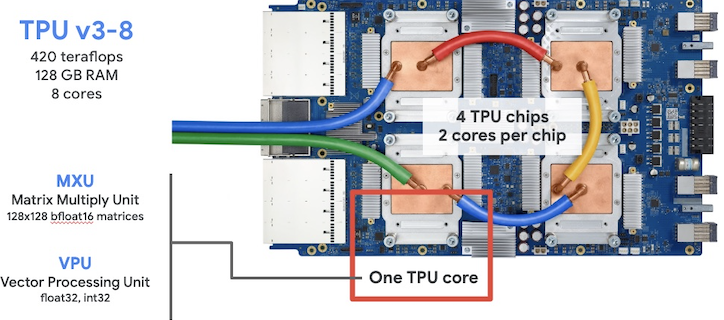

We've collected some hyperparameters here to make experimentation easier. Fork this notebook by [**clicking here**](https://www.kaggle.com/kernels/fork/12171965) to try it yourself!

In [6]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

The next few sections set up the TPU computation, data pipeline, and neural network model. If you'd just like to see the results, feel free to skip to the end!

# Setup #

In addition to our imports, this section contains some code that will connect our notebook to the TPU and create a **distribution strategy**. Each TPU has eight computational cores acting independently. With a distribution strategy, we define how we want to divide up the work between them.

In [7]:
# TF 2.3 version
# Detect and init the TPU
# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
#     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
# print("Number of accelerators: ", strategy.num_replicas_in_sync)

# TF 2.2 version
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


## Note 3 😀
Let us inspect ```strategy``` object

In [8]:
strategy.__dir__()

['_extended',
 '_scale_loss_for_estimator',
 '__module__',
 '__doc__',
 '__init__',
 'run',
 '_tf_api_names',
 '_tf_api_names_v1',
 'experimental_assign_to_logical_device',
 'experimental_split_to_logical_devices',
 'experimental_replicate_to_logical_devices',
 'experimental_distribute_values_from_function',
 'extended',
 '_scale_loss_for_estimator_enabled',
 'scope',
 'colocate_vars_with',
 'make_dataset_iterator',
 'make_input_fn_iterator',
 'experimental_make_numpy_dataset',
 'experimental_run',
 'experimental_distribute_dataset',
 'experimental_distribute_datasets_from_function',
 'experimental_run_v2',
 'reduce',
 'unwrap',
 'experimental_local_results',
 'group',
 'num_replicas_in_sync',
 'configure',
 'update_config_proto',
 '__deepcopy__',
 '__copy__',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__'

In [9]:
# Plotting
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,7]

# Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [10]:
# Data
from kaggle_datasets import KaggleDatasets
from tensorflow.io import FixedLenFeature    #Configuration for parsing a fixed-length input feature.
AUTO = tf.data.experimental.AUTOTUNE         #See Note 5 below 😀

In [11]:
# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

Notice that TensorFlow now detects eight accelerators. Using a TPU is a bit like using eight GPUs at once.

# Load Data #

The dataset has been encoded in a binary file format called *TFRecords*. These two functions will parse the TFRecords and build a TensorFlow `tf.data.Dataset` object that we can use for training.

In [12]:
def make_decoder(feature_description):
    
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        return features, label
    
    return decoder

## Note 4 😀
```make_decoder(feature_description)``` returns a function, in this case ```decoder(example)``` which takes ```example``` as input when called. This concept is also used in decorators in Python. 

Here is a beginner friendly article on them: https://realpython.com/inner-functions-what-are-they-good-for/#closures-and-factory-functions

In [13]:
def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    
    return dataset

## Note 5 😀

```AUTO = tf.data.experimental.AUTOTUNE```

GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines.
https://www.tensorflow.org/guide/data_performance

<a href="https://www.tensorflow.org/guide/data_performance"><img src=https://www.tensorflow.org/guide/images/data_performance/prefetched.svg width=1000px></a>

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."

In [14]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = steps_per_epoch

In [15]:
print(dataset_size, validation_size, training_size, batch_size, steps_per_epoch, validation_steps, steps_per_execution)

11000000 500000 10500000 16384 640 30 640


In [16]:
feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}

decoder = make_decoder(feature_description)

In [17]:
decoder

<function __main__.make_decoder.<locals>.decoder(example)>

## See Note 4 😀 above

In [18]:
data_dir = KaggleDatasets().get_gcs_path('higgs-boson')
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

In [19]:
ds_train = load_dataset(train_files, decoder, ordered=False)

ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)

ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

# Model #

Now that the data is ready, let's define the network. We're defining the deep branch of the network using Keras's *Functional API*, which is a bit more flexible that the `Sequential` method we used in the course.


In [20]:
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

In [21]:
with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

In [22]:
wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
#     experimental_steps_per_execution=steps_per_execution,
)

# Training #

During training, we'll use the `EarlyStopping` callback as usual. Notice that we've also defined a **learning rate schedule**. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by `0.2` if the validation loss didn't decrease after an epoch.

In [23]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [24]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50
640/640 [==============================] - 175s 273ms/step - binary_accuracy: 0.7111 - auc: 0.7846 - loss: 0.5683 - val_binary_accuracy: 0.7500 - val_auc: 0.8321 - val_loss: 0.5019 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 32s 50ms/step - binary_accuracy: 0.7571 - auc: 0.8400 - loss: 0.4904 - val_binary_accuracy: 0.7644 - val_auc: 0.8491 - val_loss: 0.4788 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 32s 49ms/step - binary_accuracy: 0.7662 - auc: 0.8503 - loss: 0.4762 - val_binary_accuracy: 0.7693 - val_auc: 0.8539 - val_loss: 0.4719 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 31s 49ms/step - binary_accuracy: 0.7713 - auc: 0.8558 - loss: 0.4684 - val_binary_accuracy: 0.7732 - val_auc: 0.8596 - val_loss: 0.4665 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 31s 49ms/step - binary_accuracy: 0.7751 - auc: 0.8599 - loss: 0.4623 - val_binary_accuracy: 0.7783 - val_auc: 0.8629 - val_loss: 0.4

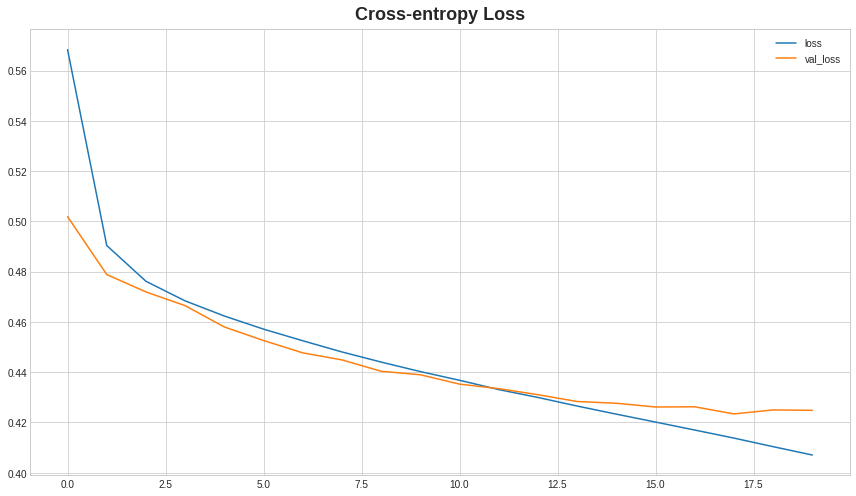

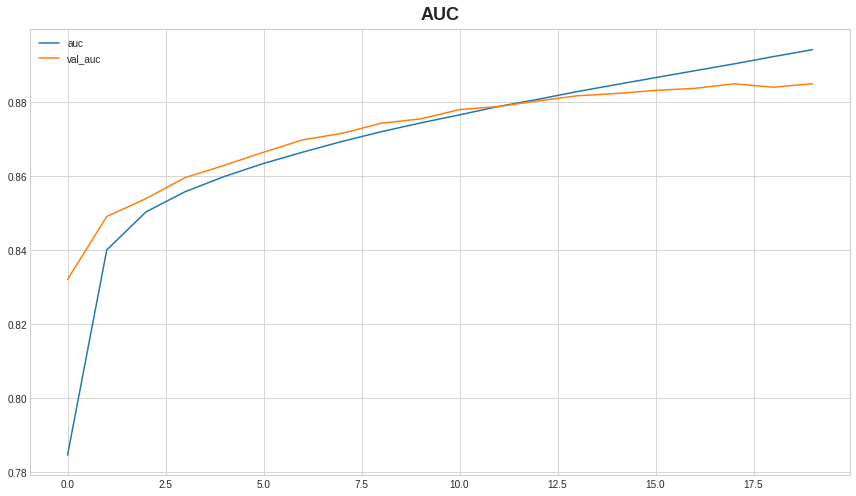

In [25]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');

## Note 6 😀

Let us inspect these 3 models and their architecture**

In [26]:
wide.summary()

Model: "linear_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  28        
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


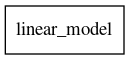

In [27]:
tf.keras.utils.plot_model(wide, show_shapes=True)

In [28]:
deep.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              59392     
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192  

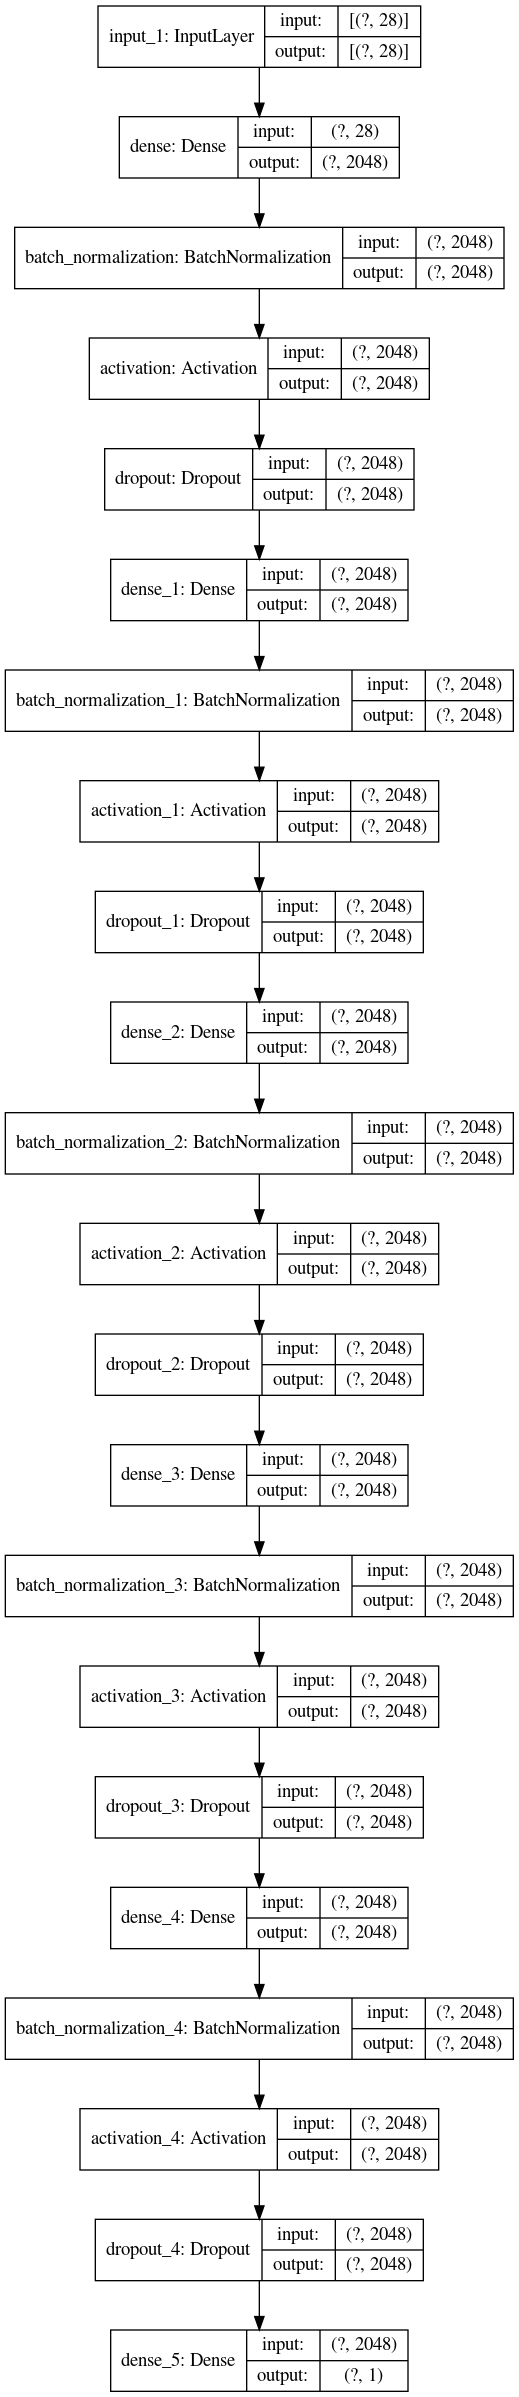

In [29]:
tf.keras.utils.plot_model(deep, show_shapes=True)

In [30]:
wide_and_deep.summary()

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_model (LinearModel)   multiple                  29        
_________________________________________________________________
model (Model)                (None, 1)                 16887809  
Total params: 16,887,838
Trainable params: 16,867,358
Non-trainable params: 20,480
_________________________________________________________________


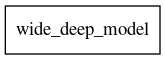

In [31]:
tf.keras.utils.plot_model(wide_and_deep, show_shapes=True)

## Note 7 😀

Let us monitor TPU and CPU usage during training

<img src=https://storage.googleapis.com/kaggle-media/tpu/tpu_monitor.png width=300px>

# References #

- Baldi, P. et al. *Searching for Exotic Particles in High-Energy Physics with Deep Learning*. (2014) ([arXiv](https://arxiv.org/abs/1402.4735))
- Cheng, H. et al. *Wide & Deep Learning for Recommender Systems*. (2016) ([arXiv](https://arxiv.org/abs/1606.07792))
- *What Exactly is the Higgs Boson?* Scientific American. (1999) [(article)](https://www.scientificamerican.com/article/what-exactly-is-the-higgs/)]

[^1]: In the original implementation, categorical features were one-hot encoded and crossed to produce the interaction features. This "wide" dataset was used with the linear component. For the deep component, the categories were encoded into a much narrower embedding layer.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum) to chat with other Learners.*